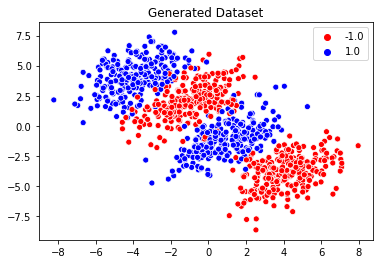

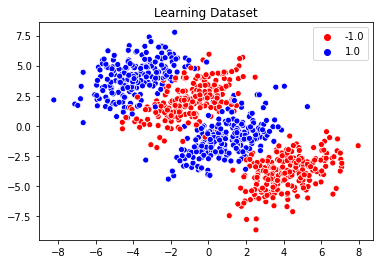

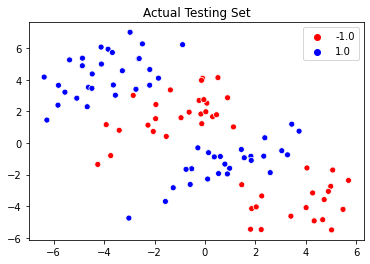

     pcost       dcost       gap    pres   dres
 0: -3.1399e+01 -7.5616e+04  2e+05  8e-01  6e-14
 1:  1.6213e+03 -2.5289e+04  3e+04  4e-02  6e-14
 2: -6.1569e+01 -5.1869e+03  5e+03  7e-03  5e-14
 3: -7.3092e+02 -2.7376e+03  2e+03  2e-03  4e-14
 4: -1.0150e+03 -2.0626e+03  1e+03  9e-04  3e-14
 5: -1.1584e+03 -1.7689e+03  6e+02  5e-04  4e-14
 6: -1.2350e+03 -1.6275e+03  4e+02  3e-04  4e-14
 7: -1.2970e+03 -1.5215e+03  2e+02  1e-04  4e-14
 8: -1.3273e+03 -1.4691e+03  1e+02  8e-05  4e-14
 9: -1.3511e+03 -1.4279e+03  8e+01  3e-05  5e-14
10: -1.3628e+03 -1.4078e+03  5e+01  9e-06  5e-14
11: -1.3741e+03 -1.3925e+03  2e+01  2e-06  5e-14
12: -1.3778e+03 -1.3874e+03  1e+01  9e-14  6e-14
13: -1.3818e+03 -1.3830e+03  1e+00  1e-13  6e-14
14: -1.3823e+03 -1.3824e+03  9e-02  8e-14  6e-14
15: -1.3824e+03 -1.3824e+03  2e-03  5e-15  6e-14
16: -1.3824e+03 -1.3824e+03  2e-05  2e-14  6e-14
Optimal solution found.
174 support vectors out of 900 points


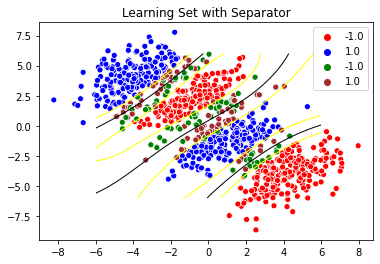

In [ ]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sbn
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def SoftMkernelSVM(X, y,C):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = gaussian_kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(n_samples) * -1)
    tmp2 = np.identity(n_samples)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(n_samples)
    tmp2 = np.ones(n_samples) * C
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    a = np.ravel(solution['x'])

    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    Alpha = a[sv]
    SV = X[sv]
    SV_y = y[sv]
    print("%d support vectors out of %d points" % (len(Alpha), n_samples))

    b = 0
    for n in range(len(Alpha)):
        b += SV_y[n]
        b -= np.sum(Alpha * SV_y * K[ind[n],sv])
    b /= len(Alpha)

    return Alpha,SV,SV_y,b

def project(X,Alpha,SV,SV_y,b):
    y_predict = np.zeros(len(X))
    for i in range(len(X)):
        s = 0
        for a, sv_y, sv in zip(Alpha, SV_y, SV):
            s += a * sv_y * gaussian_kernel(X[i], sv)
        y_predict[i] = s
    return y_predict + b

def predict(X,Alpha,SV,SV_y,b):
    return np.sign(project(X,Alpha,SV,SV_y,b))

def generatedataset(size,mean1,mean2,mean3,mean4,cov): 
  np.random.seed(0) 
  n = int(size/4)
  Y1 = np.ones(2*n)*-1.0
  x1 = np.random.multivariate_normal(mean1,cov,size=n)
  x2 = np.random.multivariate_normal(mean3,cov,size=n)
  X1 = np.concatenate((x1,x2),axis=0)
  D1 = np.c_[X1,Y1]
  
  Y2 = np.ones(2*n)
  x1 = np.random.multivariate_normal(mean2,cov,size=n)
  x2 = np.random.multivariate_normal(mean4,cov,size=n)
  X2 = np.concatenate((x1,x2),axis=0)
  D2 = np.c_[X2,Y2]
  dataset = np.concatenate((D1,D2),axis=0)
  np.random.shuffle(dataset)
  return dataset    

def plotmargin(learnset,SV,SV_y,Alpha,b):
  sbn.scatterplot(learnset[:,0],learnset[:,1],hue = learnset[:,2],palette = ['red','blue'])#.set_title('Prediction')
  sbn.scatterplot(SV[:,0],SV[:,1],hue = SV_y,palette = ['green','brown']).set_title('Learning Set with Separator')
  X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
  X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
  Z = project(X,Alpha,SV,SV_y,b).reshape(X1.shape)
  plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
  plt.contour(X1, X2, Z + 1, [0.0], colors='yellow', linewidths=1, origin='lower')
  plt.contour(X1, X2, Z - 1, [0.0], colors='yellow', linewidths=1, origin='lower')
  plt.axis("tight")
  plt.show()

def Error(testset,lst):
  c = 0
  n = len(lst)
  for i in range(n):
    if testset[i][2] != lst[i]:
      c = c+1
  return c*100/n;

size = 1000
mean1 = [-1, 2]
mean2 = [1, -1]
mean3 = [4, -4]
mean4 = [-4, 4]
cov = [[2.0,1.0], [1.0, 2.0]]
dataset = generatedataset(size,mean1,mean2,mean3,mean4,cov)
sbn.scatterplot(dataset[:,0],dataset[:,1],hue = dataset[:,2],palette = ['red','blue']).set_title('Generated Dataset')
plt.show()

learnset,testset = train_test_split(dataset, test_size=0.1, random_state=1)
sbn.scatterplot(learnset[:,0],learnset[:,1],hue = learnset[:,2],palette = ['red','blue']).set_title('Learning Dataset')
plt.show()
sbn.scatterplot(testset[:,0],testset[:,1],hue = testset[:,2],palette = ['red','blue']).set_title('Actual Testing Set')
plt.show()

C = 10
Alpha,SV,SV_y,b = SoftMkernelSVM(learnset[:,:-1],learnset[:,-1],C)
plotmargin(learnset,SV,SV_y,Alpha,b)
lst = predict(testset[:,:-1],Alpha,SV,SV_y,b)
sbn.scatterplot(testset[:,0],testset[:,1],hue = lst,palette = ['red','blue']).set_title('Prediction')
plt.show()
print("Error in prediction : "+str(Error(testset,lst))+"%")